In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [3]:
if sys.version[0] == "3": from urllib.request import urlretrieve
else: from urllib import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://www-nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("http://www-nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

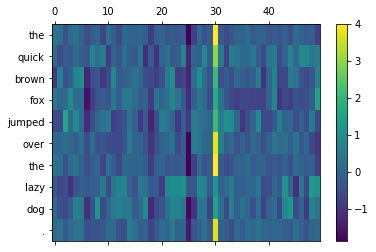

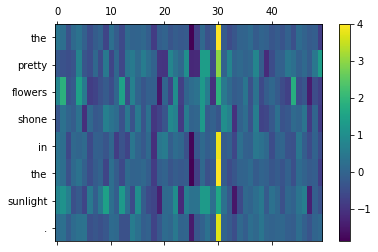

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [8]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

In [9]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [10]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e


In [11]:
tf.reset_default_graph()

In [12]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

In [13]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [14]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In [15]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

In [16]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|          | 3/782 [00:01<09:22,  1.39it/s]

Iter 0.0, Minibatch Loss= 1.118880, Training Accuracy= 0.41406


  2%|▏         | 13/782 [00:01<02:21,  5.44it/s]

Iter 10.0, Minibatch Loss= 1.088144, Training Accuracy= 0.40625


  3%|▎         | 23/782 [00:02<01:07, 11.28it/s]

Iter 20.0, Minibatch Loss= 1.093669, Training Accuracy= 0.36719


  4%|▍         | 33/782 [00:03<00:52, 14.34it/s]

Iter 30.0, Minibatch Loss= 1.098277, Training Accuracy= 0.36719


  5%|▌         | 43/782 [00:03<00:52, 14.09it/s]

Iter 40.0, Minibatch Loss= 1.087354, Training Accuracy= 0.39062


  7%|▋         | 53/782 [00:04<00:48, 14.96it/s]

Iter 50.0, Minibatch Loss= 1.075323, Training Accuracy= 0.46875


  8%|▊         | 63/782 [00:05<00:49, 14.48it/s]

Iter 60.0, Minibatch Loss= 1.087084, Training Accuracy= 0.35938


  9%|▉         | 73/782 [00:05<00:49, 14.43it/s]

Iter 70.0, Minibatch Loss= 1.094530, Training Accuracy= 0.40625


 11%|█         | 83/782 [00:06<00:48, 14.52it/s]

Iter 80.0, Minibatch Loss= 1.080012, Training Accuracy= 0.41406


 12%|█▏        | 91/782 [00:07<01:00, 11.37it/s]

Iter 90.0, Minibatch Loss= 1.080032, Training Accuracy= 0.39844


 13%|█▎        | 103/782 [00:08<00:57, 11.89it/s]

Iter 100.0, Minibatch Loss= 1.185560, Training Accuracy= 0.40625


 14%|█▍        | 113/782 [00:09<00:49, 13.45it/s]

Iter 110.0, Minibatch Loss= 1.067651, Training Accuracy= 0.50000


 16%|█▌        | 123/782 [00:09<00:45, 14.53it/s]

Iter 120.0, Minibatch Loss= 1.067986, Training Accuracy= 0.46094


 17%|█▋        | 133/782 [00:10<00:46, 14.05it/s]

Iter 130.0, Minibatch Loss= 1.049839, Training Accuracy= 0.43750


 18%|█▊        | 143/782 [00:11<00:45, 13.91it/s]

Iter 140.0, Minibatch Loss= 1.067825, Training Accuracy= 0.45312


 20%|█▉        | 153/782 [00:11<00:43, 14.44it/s]

Iter 150.0, Minibatch Loss= 1.062599, Training Accuracy= 0.42969


 21%|██        | 163/782 [00:12<00:43, 14.32it/s]

Iter 160.0, Minibatch Loss= 1.075096, Training Accuracy= 0.42969


 22%|██▏       | 173/782 [00:13<00:41, 14.80it/s]

Iter 170.0, Minibatch Loss= 1.078179, Training Accuracy= 0.48438


 23%|██▎       | 183/782 [00:13<00:42, 14.11it/s]

Iter 180.0, Minibatch Loss= 1.076858, Training Accuracy= 0.41406


 25%|██▍       | 193/782 [00:14<00:40, 14.39it/s]

Iter 190.0, Minibatch Loss= 1.059287, Training Accuracy= 0.39062


 26%|██▌       | 203/782 [00:15<00:38, 14.87it/s]

Iter 200.0, Minibatch Loss= 1.049474, Training Accuracy= 0.44531


 27%|██▋       | 213/782 [00:15<00:37, 15.08it/s]

Iter 210.0, Minibatch Loss= 1.070277, Training Accuracy= 0.42969


 29%|██▊       | 223/782 [00:16<00:37, 14.76it/s]

Iter 220.0, Minibatch Loss= 1.069427, Training Accuracy= 0.42969


 30%|██▉       | 231/782 [00:17<00:44, 12.45it/s]

Iter 230.0, Minibatch Loss= 1.035334, Training Accuracy= 0.46094


 31%|███       | 243/782 [00:18<00:44, 12.16it/s]

Iter 240.0, Minibatch Loss= 1.030936, Training Accuracy= 0.52344


 32%|███▏      | 253/782 [00:19<00:39, 13.37it/s]

Iter 250.0, Minibatch Loss= 1.025337, Training Accuracy= 0.50781


 34%|███▎      | 263/782 [00:19<00:36, 14.22it/s]

Iter 260.0, Minibatch Loss= 1.061574, Training Accuracy= 0.46094


 35%|███▍      | 273/782 [00:20<00:34, 14.75it/s]

Iter 270.0, Minibatch Loss= 1.052368, Training Accuracy= 0.49219


 36%|███▌      | 283/782 [00:21<00:33, 15.06it/s]

Iter 280.0, Minibatch Loss= 1.062466, Training Accuracy= 0.47656


 37%|███▋      | 293/782 [00:21<00:32, 15.06it/s]

Iter 290.0, Minibatch Loss= 1.021823, Training Accuracy= 0.49219


 39%|███▊      | 303/782 [00:22<00:33, 14.40it/s]

Iter 300.0, Minibatch Loss= 1.043971, Training Accuracy= 0.52344


 40%|████      | 313/782 [00:23<00:31, 14.89it/s]

Iter 310.0, Minibatch Loss= 1.044896, Training Accuracy= 0.46875


 41%|████▏     | 323/782 [00:23<00:30, 14.90it/s]

Iter 320.0, Minibatch Loss= 1.078340, Training Accuracy= 0.37500


 43%|████▎     | 333/782 [00:24<00:32, 14.02it/s]

Iter 330.0, Minibatch Loss= 1.036380, Training Accuracy= 0.48438


 44%|████▍     | 343/782 [00:25<00:30, 14.32it/s]

Iter 340.0, Minibatch Loss= 1.049838, Training Accuracy= 0.46094


 45%|████▌     | 353/782 [00:25<00:28, 15.11it/s]

Iter 350.0, Minibatch Loss= 1.047664, Training Accuracy= 0.45312


 46%|████▋     | 363/782 [00:26<00:27, 15.46it/s]

Iter 360.0, Minibatch Loss= 1.039294, Training Accuracy= 0.42969


 48%|████▊     | 373/782 [00:27<00:26, 15.51it/s]

Iter 370.0, Minibatch Loss= 1.069536, Training Accuracy= 0.43750


 49%|████▉     | 383/782 [00:27<00:25, 15.57it/s]

Iter 380.0, Minibatch Loss= 1.092009, Training Accuracy= 0.36719


 50%|█████     | 393/782 [00:28<00:24, 15.57it/s]

Iter 390.0, Minibatch Loss= 1.072459, Training Accuracy= 0.49219


 52%|█████▏    | 403/782 [00:29<00:24, 15.58it/s]

Iter 400.0, Minibatch Loss= 1.066622, Training Accuracy= 0.43750


 53%|█████▎    | 413/782 [00:29<00:23, 15.45it/s]

Iter 410.0, Minibatch Loss= 1.047420, Training Accuracy= 0.46875


 54%|█████▍    | 423/782 [00:30<00:23, 15.01it/s]

Iter 420.0, Minibatch Loss= 1.064384, Training Accuracy= 0.42969


 55%|█████▌    | 433/782 [00:30<00:22, 15.48it/s]

Iter 430.0, Minibatch Loss= 1.018015, Training Accuracy= 0.50000


 57%|█████▋    | 443/782 [00:31<00:22, 14.90it/s]

Iter 440.0, Minibatch Loss= 1.051622, Training Accuracy= 0.46094


 58%|█████▊    | 453/782 [00:32<00:21, 14.96it/s]

Iter 450.0, Minibatch Loss= 1.022696, Training Accuracy= 0.56250


 59%|█████▉    | 463/782 [00:32<00:21, 15.12it/s]

Iter 460.0, Minibatch Loss= 1.018428, Training Accuracy= 0.52344


 60%|██████    | 473/782 [00:33<00:20, 15.16it/s]

Iter 470.0, Minibatch Loss= 1.004266, Training Accuracy= 0.55469


 62%|██████▏   | 483/782 [00:34<00:19, 15.57it/s]

Iter 480.0, Minibatch Loss= 1.031036, Training Accuracy= 0.49219


 63%|██████▎   | 493/782 [00:34<00:18, 15.64it/s]

Iter 490.0, Minibatch Loss= 1.080269, Training Accuracy= 0.43750


 64%|██████▍   | 503/782 [00:35<00:17, 15.62it/s]

Iter 500.0, Minibatch Loss= 1.065894, Training Accuracy= 0.46094


 66%|██████▌   | 513/782 [00:36<00:17, 15.56it/s]

Iter 510.0, Minibatch Loss= 1.063315, Training Accuracy= 0.47656


 67%|██████▋   | 523/782 [00:36<00:17, 15.11it/s]

Iter 520.0, Minibatch Loss= 1.054603, Training Accuracy= 0.46875


 68%|██████▊   | 533/782 [00:37<00:16, 15.48it/s]

Iter 530.0, Minibatch Loss= 1.049439, Training Accuracy= 0.50781


 69%|██████▉   | 543/782 [00:38<00:18, 12.58it/s]

Iter 540.0, Minibatch Loss= 1.079491, Training Accuracy= 0.39062


 71%|███████   | 552/782 [00:39<00:27,  8.48it/s]

Iter 550.0, Minibatch Loss= 1.057841, Training Accuracy= 0.42969


 72%|███████▏  | 564/782 [00:40<00:19, 11.09it/s]

Iter 560.0, Minibatch Loss= 1.064527, Training Accuracy= 0.48438


 73%|███████▎  | 572/782 [00:41<00:17, 12.23it/s]

Iter 570.0, Minibatch Loss= 1.017023, Training Accuracy= 0.55469


 75%|███████▍  | 584/782 [00:42<00:17, 11.02it/s]

Iter 580.0, Minibatch Loss= 1.053622, Training Accuracy= 0.48438


 76%|███████▌  | 592/782 [00:42<00:16, 11.20it/s]

Iter 590.0, Minibatch Loss= 1.059896, Training Accuracy= 0.43750


 77%|███████▋  | 604/782 [00:43<00:12, 13.77it/s]

Iter 600.0, Minibatch Loss= 1.034869, Training Accuracy= 0.49219


 78%|███████▊  | 612/782 [00:44<00:16, 10.06it/s]

Iter 610.0, Minibatch Loss= 1.040174, Training Accuracy= 0.53125


 80%|███████▉  | 622/782 [00:45<00:21,  7.37it/s]

Iter 620.0, Minibatch Loss= 0.999681, Training Accuracy= 0.54688


 81%|████████  | 632/782 [00:46<00:12, 11.80it/s]

Iter 630.0, Minibatch Loss= 1.034889, Training Accuracy= 0.46875


 82%|████████▏ | 644/782 [00:47<00:09, 14.06it/s]

Iter 640.0, Minibatch Loss= 1.028382, Training Accuracy= 0.50781


 83%|████████▎ | 652/782 [00:48<00:16,  7.93it/s]

Iter 650.0, Minibatch Loss= 1.011249, Training Accuracy= 0.49219


 85%|████████▍ | 662/782 [00:49<00:11, 10.03it/s]

Iter 660.0, Minibatch Loss= 1.018264, Training Accuracy= 0.51562


 86%|████████▌ | 672/782 [00:50<00:08, 12.78it/s]

Iter 670.0, Minibatch Loss= 1.026383, Training Accuracy= 0.47656


 87%|████████▋ | 682/782 [00:51<00:10,  9.70it/s]

Iter 680.0, Minibatch Loss= 1.045176, Training Accuracy= 0.48438


 89%|████████▊ | 694/782 [00:52<00:07, 12.51it/s]

Iter 690.0, Minibatch Loss= 1.036672, Training Accuracy= 0.46875


 90%|█████████ | 704/782 [00:52<00:05, 13.86it/s]

Iter 700.0, Minibatch Loss= 1.049109, Training Accuracy= 0.44531


 91%|█████████ | 712/782 [00:53<00:07,  9.26it/s]

Iter 710.0, Minibatch Loss= 1.071600, Training Accuracy= 0.46875


 92%|█████████▏| 723/782 [00:55<00:07,  8.42it/s]

Iter 720.0, Minibatch Loss= 1.020035, Training Accuracy= 0.47656


 94%|█████████▎| 733/782 [00:56<00:04, 10.21it/s]

Iter 730.0, Minibatch Loss= 1.040412, Training Accuracy= 0.48438


 95%|█████████▍| 742/782 [00:57<00:05,  7.92it/s]

Iter 740.0, Minibatch Loss= 0.994069, Training Accuracy= 0.51562


 96%|█████████▌| 752/782 [00:58<00:04,  7.00it/s]

Iter 750.0, Minibatch Loss= 1.014977, Training Accuracy= 0.54688


 98%|█████████▊| 763/782 [00:59<00:02,  9.24it/s]

Iter 760.0, Minibatch Loss= 1.020595, Training Accuracy= 0.53125


 99%|█████████▊| 772/782 [01:00<00:00, 10.27it/s]

Iter 770.0, Minibatch Loss= 0.975701, Training Accuracy= 0.55469


100%|██████████| 782/782 [01:01<00:00, 12.70it/s]

Iter 780.0, Minibatch Loss= 1.003754, Training Accuracy= 0.55469


In [17]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Positive entailment


In [18]:
sess.close()